# Term Depost Marketing

## Background
#### We are small startup is focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

#### We are interested in developing a robust machine learning system that leverages information coming from call center data.

#### Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Goals
#### - Predict if a customer will subscribe to a term deposit.
#### - Find out which customers are more likely to buy the investment product.
#### - Determine which features make the customer buy.  


## Success Criteria
#### Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.



# ------------------------------------------------------------------------
## Setup

In [1]:
#install libraries
!pip install pycaret
!pip install imbalanced-learn
!pip install optuna lightgbm
!pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.8 MB/s eta 0:00:00


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
import logging
import random
import lightgbm as lgb
import requests
import sys
import optuna
import duckdb as dd
import umap
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.feature_selection import RFE
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope
from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, predict_model
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# code to suppress lightGBM when running Lazy Classifer
class CustomLogger:
    def __init__(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        pass# Suppress warnings by not doing anything pass

    def error(self, message):
        self.logger.error(message)
# Register the custom logger
lgb.register_logger(CustomLogger())

In [4]:
# connect to personal google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# define function to download file from google drive
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7'
destination = 'term-deposit-marketing-2020.csv'
download_file_from_google_drive(file_id, destination)
df=pd.read_csv(destination)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [6]:
# setup duck db connection
conn = dd.connect()

# Exploratory Data Analysis

In [7]:
# check for missing values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [8]:
# check data types
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [9]:
print(df.describe())
print(df.describe(include=['object']))

                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000
                job  marital  education default housing   loan   contact  \
count         40000    40000      40000   40000   40000  40000     40000   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
fre

In [10]:
# filter df for subscribed
subscribed_df = conn.execute('''
    SELECT *
    FROM df
    WHERE y = 'yes'
      ''').fetchdf()

# get statistical summary for continuous features
print('subscribed:')
print(subscribed_df.describe())

# filter df for unsubscribed
not_subscribed_df = conn.execute('''
    SELECT *
    FROM df
    WHERE y = 'no'
      ''').fetchdf()

# get statistical summary for continuous features
print('not subscribed:')
print(not_subscribed_df.describe())

subscribed:
               age       balance          day     duration     campaign
count  2896.000000   2896.000000  2896.000000  2896.000000  2896.000000
mean     39.844959   1588.495856    15.827003   682.958564     2.414365
std      11.001984   2924.894429     8.557604   431.287174     2.306015
min      19.000000  -3058.000000     1.000000     8.000000     1.000000
25%      31.000000    141.000000     8.000000   364.000000     1.000000
50%      37.000000    620.000000    16.000000   629.000000     2.000000
75%      47.000000   1820.500000    22.000000   913.000000     3.000000
max      95.000000  45248.000000    31.000000  3881.000000    32.000000
not subscribed:
                age        balance           day      duration      campaign
count  37104.000000   37104.000000  37104.000000  37104.000000  37104.000000
mean      40.599208    1249.752533     16.032072    221.408042      2.918688
std        9.525450    2900.722436      8.255850    206.360022      3.298031
min       19.000

In [11]:
#  get statistical summary for categorical features
print('subscribed:')
print(subscribed_df.describe(include=object))
print('not subscribed:')
print(not_subscribed_df.describe(include=object))

subscribed:
               job  marital  education default housing  loan   contact month  \
count         2896     2896       2896    2896    2896  2896      2896  2896   
unique          12        3          4       2       2     2         3    11   
top     management  married  secondary      no     yes    no  cellular   may   
freq           676     1478       1418    2847    1464  2516      2233   791   

           y  
count   2896  
unique     1  
top      yes  
freq    2896  
not subscribed:
                job  marital  education default housing   loan   contact  \
count         37104    37104      37104   37104   37104  37104     37104   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
freq           8848    22908      19575   36344   22567  30554     22681   

        month      y  
count   37104  37104  
unique     11      1  
top       may     no  
freq    12741  37104  


In [12]:
# list unique values and counts in categorical columns
for column in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']:
    unique_values = df[column].value_counts()
    print(f"Value counts in column '{column}':")
    print(unique_values)
    print("\n")

Value counts in column 'job':
job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64


Value counts in column 'marital':
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64


Value counts in column 'education':
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64


Value counts in column 'default':
default
no     39191
yes      809
Name: count, dtype: int64


Value counts in column 'housing':
housing
yes    24031
no     15969
Name: count, dtype: int64


Value counts in column 'loan':
loan
no     33070
yes     6930
Name: count, dtype: int64


Value counts in column 'contact':
contact
cellular     24914
unknown      12765
telephone     2321
Name: count, dtype:

# Phase 1:  Determine customers that are more like to buy the investment product.

## Data Wrangling

In [13]:
# replace yes, no with 1 and 0
df.replace(['no', 'yes'], [0,1], inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [14]:
# create a month number column
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

# Apply the mapping to the 'month' column
df['month_number'] = df['month'].map(month_map)
# Remove month column
df.drop('month', axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,y,month_number
0,58,management,married,tertiary,0,2143,1,0,unknown,5,261,1,0,5
1,44,technician,single,secondary,0,29,1,0,unknown,5,151,1,0,5
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,76,1,0,5
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,92,1,0,5
4,33,unknown,single,unknown,0,1,0,0,unknown,5,198,1,0,5


In [15]:
#split data between target 'Y' and variables 'X'
X = df.drop('y',axis=1)
Y = df['y']
print(Y)
print(X.head())

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64
   age           job  marital  education  default  balance  housing  loan  \
0   58    management  married   tertiary        0     2143        1     0   
1   44    technician   single  secondary        0       29        1     0   
2   33  entrepreneur  married  secondary        0        2        1     1   
3   47   blue-collar  married    unknown        0     1506        1     0   
4   33       unknown   single    unknown        0        1        0     0   

   contact  day  duration  campaign  month_number  
0  unknown    5       261         1             5  
1  unknown    5       151         1             5  
2  unknown    5        76         1             5  
3  unknown    5        92         1             5  
4  unknown    5       198         1             5  


In [16]:
# Split data out customer related data
X_customer_cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']
X_customer_raw = X[X_customer_cols]
X_customer_raw.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0


## Data Visualization

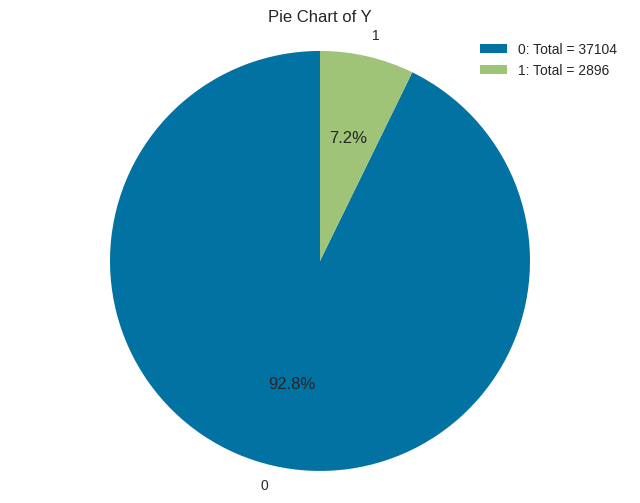

In [17]:
# Replace this with your actual data and labels
y_counts = df['y'].value_counts()
labels = y_counts.index
sizes = y_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


#### Pie chart shows highly imbalance data with ~ 93% unsubsribed



### Subscription status by categorical features

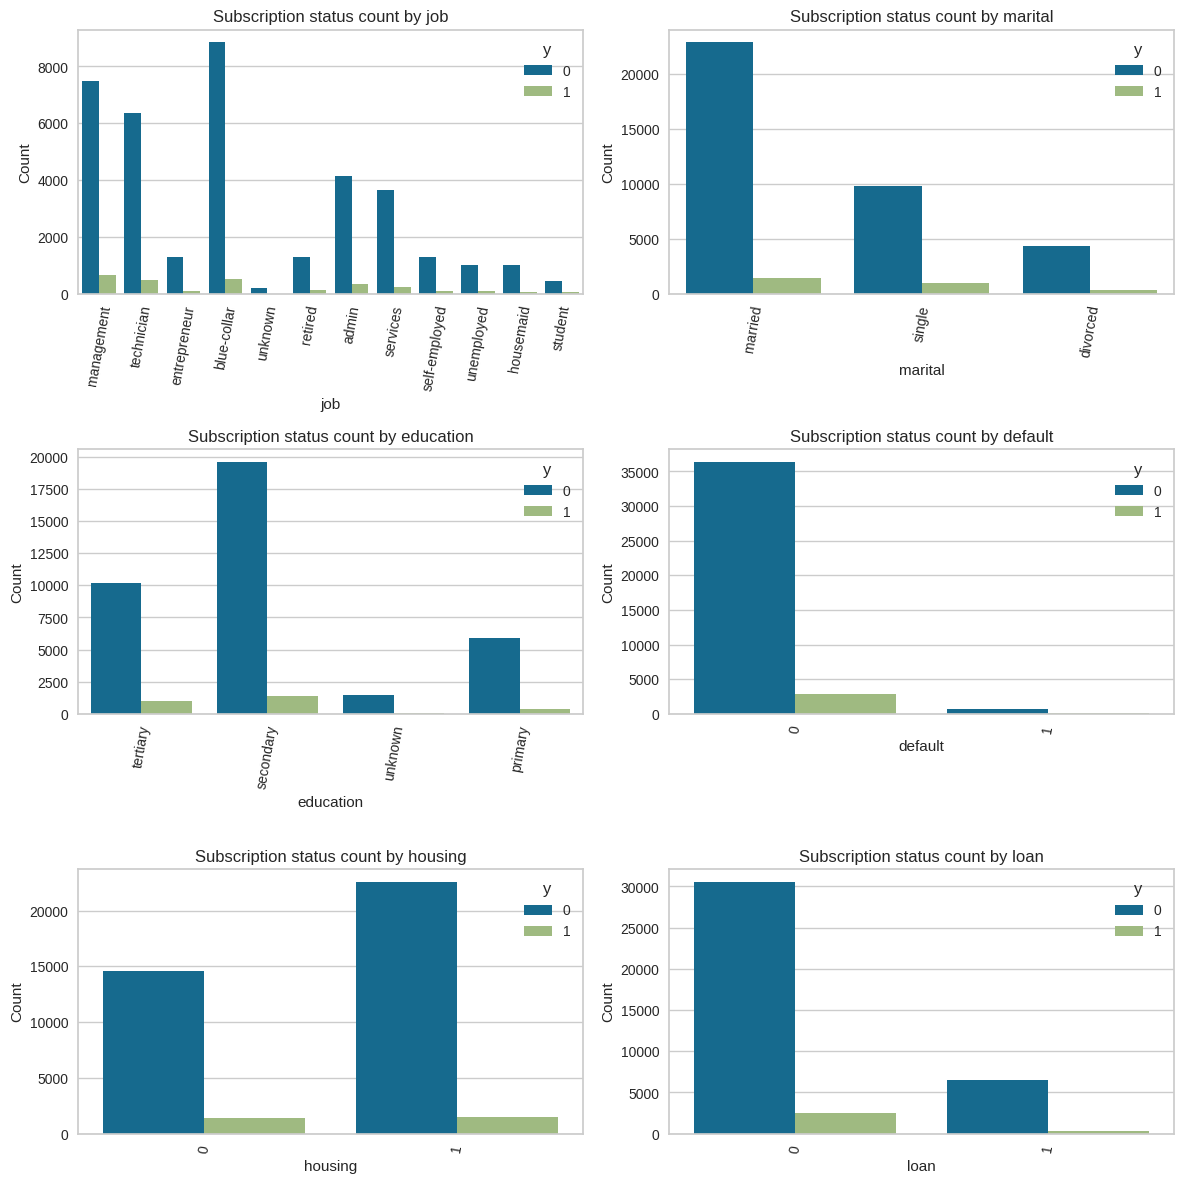

In [18]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['job', 'marital', 'education', 'default', 'housing', 'loan']):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Subscription status count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### Subscription status by continous features

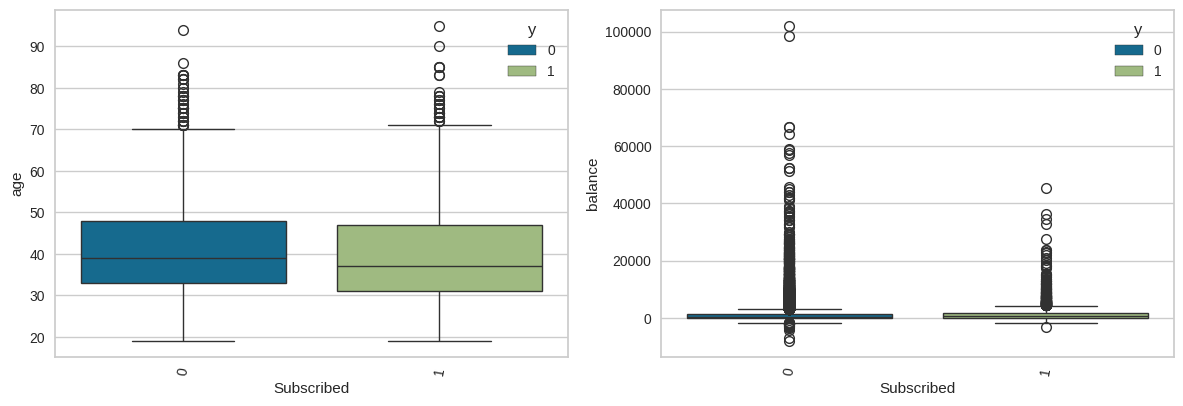

In [19]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['age', 'balance']):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=col, x='y', data=df, hue='y')
    plt.xlabel('Subscribed')
    plt.ylabel(col)
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

## Data Rebalancing and Model Selection

In [20]:
X_customer_raw

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0
...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,0,395,0,0
39996,30,management,single,tertiary,0,3340,0,0
39997,54,admin,divorced,secondary,0,200,0,0
39998,34,management,married,tertiary,0,1047,0,0


In [21]:
# convert categorical columns with one hot encoding
X_customer = pd.get_dummies(data=X_customer_raw, columns=(['job', 'marital', 'education']), drop_first=True)

# scaling of continous features
continous_cols = ['age', 'balance']
transform = preprocessing.StandardScaler()
X_customer[continous_cols] = transform.fit_transform(X_customer[continous_cols])
# convert binary values to float type
X_customer = X_customer.astype(float)
X_customer.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,1.810415,0.0,0.299174,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.358382,0.0,-0.428854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.782501,0.0,-0.438152,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.669532,0.0,0.079802,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.782501,0.0,-0.438497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [22]:
# convert target values to float type

Y = Y.astype(float)
Y.head()

,y
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [23]:
# good seeds 4134
# seed = random.randint(1000,9999)
seed = 4134
print(seed)

4134


In [24]:
# Splitting training and testing sets before rebalancing to preserve
X_train, X_test, y_train, y_test = train_test_split(X_customer,Y, test_size=0.2, random_state=seed)
print(f'X_train shape:',X_train.shape)
print(f'y_train shape:',y_train.shape)
print(f'X_test shape:',X_test.shape)
print(f'y_test shape:',y_test.shape)

X_train shape: (32000, 21)
y_train shape: (32000,)
X_test shape: (8000, 21)
y_test shape: (8000,)


### Method 1:  Random Undersampler

In [25]:
rus = RandomUnderSampler(random_state=seed)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f'X_train resample:',X_rus.shape)
print(f'y_train resample:',y_rus.shape)

X_train resample: (4636, 21)
y_train resample: (4636,)


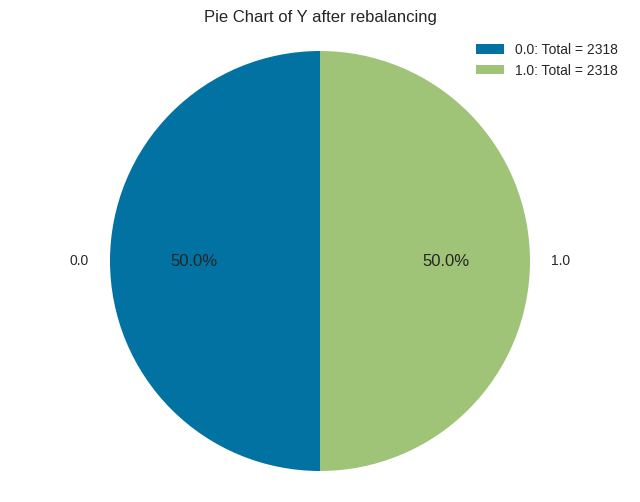

In [26]:
# Replace this with your actual data and labels
y_rus_counts = y_rus.value_counts()
labels = y_rus_counts.index
sizes = y_rus_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with RUS



In [27]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_rus, pd.DataFrame(y_rus, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,4134
1,Target,y
2,Target type,Binary
3,Original data shape,"(4636, 22)"
4,Transformed data shape,"(4636, 22)"
5,Transformed train set shape,"(3245, 22)"
6,Transformed test set shape,"(1391, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5840,0.6192,0.5515,0.5900,0.5694,0.1680,0.1686,0.3320
ada,Ada Boost Classifier,0.5818,0.6109,0.5527,0.5869,0.5690,0.1637,0.1641,0.1880
lr,Logistic Regression,0.5806,0.6040,0.5527,0.5855,0.5682,0.1612,0.1616,3.1300
ridge,Ridge Classifier,0.5784,0.6039,0.5508,0.5831,0.5661,0.1569,0.1573,0.0400
lda,Linear Discriminant Analysis,0.5781,0.6039,0.5496,0.5829,0.5653,0.1563,0.1567,0.0400
rf,Random Forest Classifier,0.5667,0.5872,0.5588,0.5675,0.5629,0.1334,0.1336,0.8020
et,Extra Trees Classifier,0.5612,0.5726,0.5607,0.5615,0.5609,0.1224,0.1225,0.4880
qda,Quadratic Discriminant Analysis,0.5562,0.5879,0.2902,0.6328,0.3909,0.1127,0.1377,0.0400
knn,K Neighbors Classifier,0.5547,0.5757,0.5379,0.5565,0.5468,0.1094,0.1095,0.1940
xgboost,Extreme Gradient Boosting,0.5544,0.5745,0.5484,0.5549,0.5510,0.1088,0.1091,0.2540


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5950,0.6166,0.5363,0.0945,0.1606,0.0430,0.0715


### Method 2:  SMOTE-ENN

In [28]:
sme = SMOTEENN(random_state=seed)
X_sme, y_sme = sme.fit_resample(X_train, y_train)
print(f'X_train resample:',X_sme.shape)
print(f'y_train resample:',y_sme.shape)

X_train resample: (38297, 21)
y_train resample: (38297,)


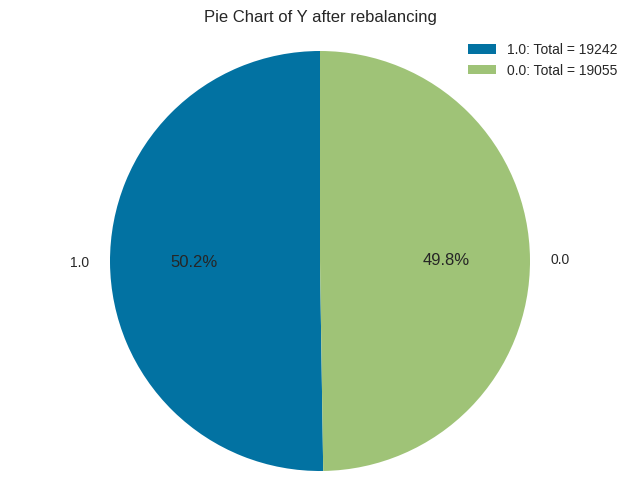

In [29]:
# Replace this with your actual data and labels
y_sme_counts = y_sme.value_counts()
labels = y_sme_counts.index
sizes = y_sme_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with SMOTE-ENN

In [30]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_sme, pd.DataFrame(y_sme, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,4134
1,Target,y
2,Target type,Binary
3,Original data shape,"(38297, 22)"
4,Transformed data shape,"(38297, 22)"
5,Transformed train set shape,"(26807, 22)"
6,Transformed test set shape,"(11490, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9754,0.9963,0.9732,0.9778,0.9755,0.9508,0.9509,3.0320
rf,Random Forest Classifier,0.9573,0.9903,0.9495,0.9649,0.9571,0.9145,0.9146,3.1460
lightgbm,Light Gradient Boosting Machine,0.9241,0.9712,0.8822,0.9637,0.9211,0.8482,0.8514,1.6160
xgboost,Extreme Gradient Boosting,0.9145,0.9699,0.8773,0.9487,0.9116,0.8291,0.8315,0.6140
dt,Decision Tree Classifier,0.9048,0.9048,0.9104,0.9012,0.9058,0.8097,0.8097,0.1920
knn,K Neighbors Classifier,0.9046,0.9701,0.9366,0.8811,0.9080,0.8092,0.8108,2.1320
gbc,Gradient Boosting Classifier,0.7928,0.8797,0.7811,0.8017,0.7912,0.5857,0.5859,3.4060
ada,Ada Boost Classifier,0.6973,0.7758,0.6991,0.6990,0.6989,0.3946,0.3948,0.9900
lr,Logistic Regression,0.6297,0.6731,0.6219,0.6342,0.6279,0.2595,0.2596,0.1460
ridge,Ridge Classifier,0.6283,0.6725,0.6193,0.6330,0.6260,0.2566,0.2567,0.0860


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7592,0.5962,0.3304,0.1104,0.1655,0.0641,0.0774


### Method 3:  SMOTE-Tomek

In [31]:
smt = SMOTETomek(random_state=seed)
X_smt, y_smt = smt.fit_resample(X_train, y_train)
print(f'X_train resample:',X_smt.shape)
print(f'y_train resample:',y_smt.shape)

X_train resample: (55674, 21)
y_train resample: (55674,)


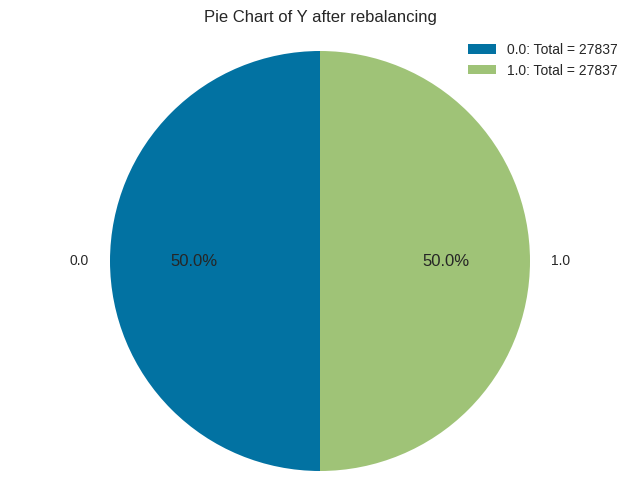

In [32]:
# Replace this with your actual data and labels
y_smt_counts = y_smt.value_counts()
labels = y_smt_counts.index
sizes = y_smt_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with SMOTE-Tomek

In [33]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_smt, pd.DataFrame(y_smt, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,4134
1,Target,y
2,Target type,Binary
3,Original data shape,"(55674, 22)"
4,Transformed data shape,"(55674, 22)"
5,Transformed train set shape,"(38971, 22)"
6,Transformed test set shape,"(16703, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9049,0.9518,0.8276,0.9789,0.8969,0.8098,0.8196,1.7900
et,Extra Trees Classifier,0.8935,0.9527,0.8923,0.8944,0.8933,0.7869,0.7870,9.1900
dt,Decision Tree Classifier,0.8859,0.8866,0.8859,0.8859,0.8859,0.7718,0.7718,0.3220
rf,Random Forest Classifier,0.8830,0.9487,0.8754,0.8889,0.8821,0.7660,0.7661,7.5060
xgboost,Extreme Gradient Boosting,0.8747,0.9395,0.8041,0.9363,0.8652,0.7494,0.7570,0.9720
knn,K Neighbors Classifier,0.7961,0.8725,0.8655,0.7599,0.8093,0.5921,0.5979,3.3780
gbc,Gradient Boosting Classifier,0.7694,0.8554,0.7488,0.7811,0.7646,0.5389,0.5394,4.0640
ada,Ada Boost Classifier,0.6533,0.7216,0.6822,0.6451,0.6628,0.3066,0.3074,1.8820
lr,Logistic Regression,0.5915,0.6229,0.5949,0.5909,0.5928,0.1830,0.1830,0.3180
ridge,Ridge Classifier,0.5914,0.6229,0.5949,0.5908,0.5928,0.1828,0.1829,0.1780


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9144,0.6091,0.1073,0.2684,0.1533,0.1168,0.1306


## Best peforming rebalancing method and model combination
####  The Extra Trees classifer using SMOTE-ENN rebalanced data had the highest pefromance with an F1-score of 0.1655.

## Model Optimatization and Evaluation

In [34]:
# define a confusion matrix plotter for visualizing classification report results
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['not subsribed', 'subscribed']); ax.yaxis.set_ticklabels(['not subsribed', 'subscribed'])
    plt.show()

## Extra Trees Classifier with Smote-ENN re-balanced data





Number of finished trials: 97
Best trial parameters: {'n_estimators': 128, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
Best trial value: 0.18765432098765433
                precision    recall  f1-score   support

Not Subscribed       0.95      0.68      0.79      7422
    Subscribed       0.11      0.53      0.19       578

      accuracy                           0.67      8000
     macro avg       0.53      0.60      0.49      8000
  weighted avg       0.89      0.67      0.75      8000



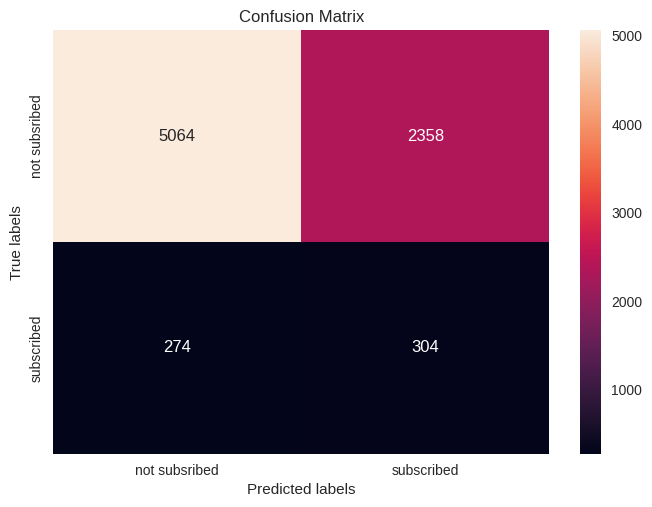

In [35]:
# optimizing Extra trees classfier with optuna.  Class weight set to balanced to adjust class weights.

optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])

    model = ExtraTreesClassifier(
        class_weight='balanced',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=seed
    )
    model.fit(X_sme, y_sme)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials:", len(study.trials))
print("Best trial parameters:", study.best_trial.params)
print("Best trial value:", study.best_trial.value)

best_params_et = study.best_trial.params
et_best = ExtraTreesClassifier(**best_params_et, class_weight='balanced', random_state=seed)
et_best.fit(X_sme, y_sme)
y_pred = et_best.predict(X_test)

report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)
plot_confusion_matrix(y_test, y_pred)

## Final Model Results
#### After optimization recall of subscribers improved to 0.54 while maintaining precision of 0.11.   The model successfully captured 54% of subscribers by reaching out to 65% less customers.  If the customer quantity was maintained at 8000 calls focusing only on likely subscribers as predicted by the model, 905 subscribers could be reached compared to the current 575, a 57% increase.

In [36]:
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame for easier handling
cm_df = pd.DataFrame(cm, columns=['Predicted Not Subscribed', 'Predicted Subscribed'],
                     index=['Actual Not Subscribed', 'Actual Subscribed'])

# Save the DataFrame to a CSV file
cm_df.to_csv('confusion_matrix.csv')



## Customer segmentation

In [37]:
X_test.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
28553,-1.508517,0.0,-0.317618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
13490,0.773249,0.0,-0.509440,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
36755,0.047233,0.0,1.471803,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
25714,1.395549,0.0,-0.305909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2556,1.084399,0.0,-0.279391,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [38]:
# Splitting training and testing sets before rebalancing to preserve
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X,Y, test_size=0.2, random_state=seed)
X_test_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,month_number
28553,26,student,single,secondary,0,352,0,0,cellular,29,202,2,1
13490,48,technician,married,secondary,0,-205,1,1,cellular,9,112,1,7
36755,41,management,single,secondary,0,5548,1,0,cellular,12,128,2,5
25714,54,services,married,unknown,0,386,0,1,cellular,19,74,1,11
2556,51,technician,married,secondary,0,463,1,0,unknown,13,213,5,5


In [58]:
# add y_pred to X using X index

df_pred = X_test_raw

df_pred['y_pred'] = y_pred
df_pred['y_actual'] = y_test_raw
print(df_pred.shape)
print(df_pred.head())



(8000, 15)
       age         job  marital  education  default  balance  housing  loan  \
28553   26     student   single  secondary        0      352        0     0   
13490   48  technician  married  secondary        0     -205        1     1   
36755   41  management   single  secondary        0     5548        1     0   
25714   54    services  married    unknown        0      386        0     1   
2556    51  technician  married  secondary        0      463        1     0   

        contact  day  duration  campaign  month_number  y_pred  y_actual  
28553  cellular   29       202         2             1     1.0       0.0  
13490  cellular    9       112         1             7     0.0       0.0  
36755  cellular   12       128         2             5     0.0       0.0  
25714  cellular   19        74         1            11     0.0       0.0  
2556    unknown   13       213         5             5     0.0       0.0  


In [69]:
# sum call durations for predicted subscribers and total
true_pos_sub = cm[1,1]
actual_sub = df_pred['y_actual'].sum()

print(f"Predicted Subscribers: {true_pos_sub}")
print(f"Actual Subscribers: {actual_sub}")

# sum call durations for predicted subscribers and total
campaigns_pred_sub = df_pred.loc[df_pred['y_pred'] == 1, 'campaign'].sum()
campaigns_total = df_pred['campaign'].sum()

print(f"Sum of campaigns where y_pred = 1: {campaigns_pred_sub}")
print(f"Sum of campaigns for all y_pred: {campaigns_total}")

sub_rate_pred = campaigns_pred_sub/true_pos_sub
sub_rate_actual = campaigns_total/actual_sub

print(f"Campaigns per subcriber predicted: {sub_rate_pred}")
print(f"Campaigns per subscriber actual: {sub_rate_actual}")

sub_rate_improvement = (sub_rate_actual - sub_rate_pred)/sub_rate_actual
print(f"Improvement in campaigns per subscriber: {sub_rate_improvement}")



Predicted Subscribers: 304
Actual Subscribers: 578.0
Sum of campaigns where y_pred = 1: 7867
Sum of campaigns for all y_pred: 23074
Campaigns per subcriber predicted: 25.87828947368421
Campaigns per subscriber actual: 39.9204152249135
Improvement in campaigns per subscriber: 0.35175299836224877


In [41]:
# add y_pred to X expanded using X index
df_pred_exp = []
df_pred_exp = X_test
df_pred_exp['campaign'] = df_pred['campaign']
df_pred_exp['age'] = df_pred['age']
df_pred_exp['balance'] = df_pred['balance']
df_pred_exp['y_pred'] = y_pred
df_pred_exp.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,campaign,y_pred
28553,26,0.0,352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2,1.0
13490,48,0.0,-205,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0.0
36755,41,0.0,5548,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2,0.0
25714,54,0.0,386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0
2556,51,0.0,463,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5,0.0


In [42]:
# filter df for subscribed
predicted_sub = conn.execute('''
    SELECT *
    FROM df_pred_exp
    WHERE y_pred = 1
      ''').fetchdf()

predicted_sub = predicted_sub.drop('y_pred', axis=1)
predicted_sub.head()


,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,campaign
0,26,0.0,352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
1,30,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2
2,51,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5
3,55,0.0,168,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2
4,30,0.0,191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2


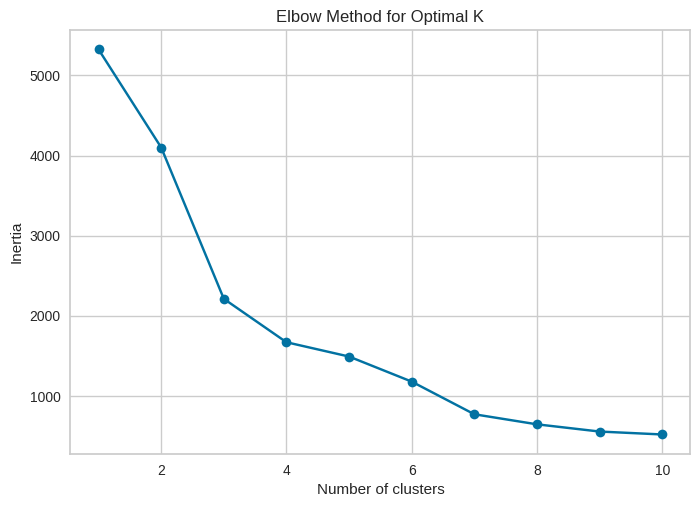

In [43]:
# Select relevant features for clustering
features_for_clustering = ['age', 'balance']  # You can add more features if needed
X_cluster = predicted_sub[features_for_clustering]

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Determine the optimal number of clusters using the elbow method (optional)
n_samples = X_cluster_scaled.shape[0]
inertia = []
for i in range(1, min(11, n_samples)):  # Limit clusters to less than or equal to number of samples
    kmeans = KMeans(n_clusters=i, random_state=seed)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, min(11, n_samples)), inertia, marker='o') #update range for plot
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



#### Using the elbow method, the optimal number of clusters is 3.

In [44]:
# Based on the elbow method or other analysis, choose the number of clusters
n_clusters = 3  # Replace with the optimal number of clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(X_cluster_scaled)

# Add cluster labels to the DataFrame
predicted_sub['cluster'] = kmeans.labels_

# Select only numeric columns for calculating the mean
numeric_predicted_sub = predicted_sub.select_dtypes(include=np.number)

print(numeric_predicted_sub.groupby('cluster').mean()) # Calculate mean for numeric columns only

# You can also visualize the clusters using scatter plots or other methods.
# For example:
#sns.scatterplot(x='age', y='balance', hue='cluster', data=predicted_sub)
#plt.show()

#print(predicted_sub.head())


               age   default       balance   housing      loan  \
cluster                                                          
0        40.568966  0.000000  16926.982759  0.327586  0.000000   
1        52.003623  0.001208   1360.117150  0.102657  0.022947   
2        32.776464  0.002815    998.783221  0.444820  0.046734   

         job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
cluster                                                                     
0               0.034483          0.017241       0.000000        0.620690   
1               0.053140          0.027778       0.003623        0.271739   
2               0.160473          0.011261       0.002815        0.292793   

         job_retired  ...  job_student  job_technician  job_unemployed  \
cluster               ...                                                
0           0.051724  ...     0.034483        0.172414        0.017241   
1           0.221014  ...     0.001208        0.187198       

# Customer segments
#### 3 customer segments were identified.  Common between the 3 cluster are mostly with education secondary or above.  No personal loans or credit in default. It approx. 3 calls to turn the customers into subscribers.
#### Segment 0:  Younger with average age of 32 yrs, mostly single, higher rate of having a home loan, with an average balance of $1000.

#### Segment 1:  Middle aged with average age of 40 yrs, moderate rate of of having a home loan, with an average balance of $18000.

#### Segment 2:  Older with average age of 51 yrs, marjority married, lower rate of having a home loan, with an average balance of $1300.

## Cluster visualization using T-SNE

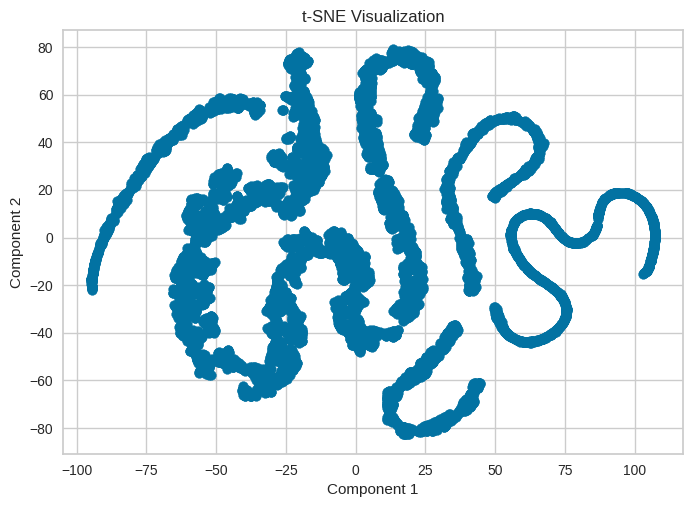

In [45]:
X_values = X_test.values
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=seed)  # Reduce to 2D for visualization
X_embedded = tsne.fit_transform(X_values)

# Visualize the results
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Cluster visualization using UMAP

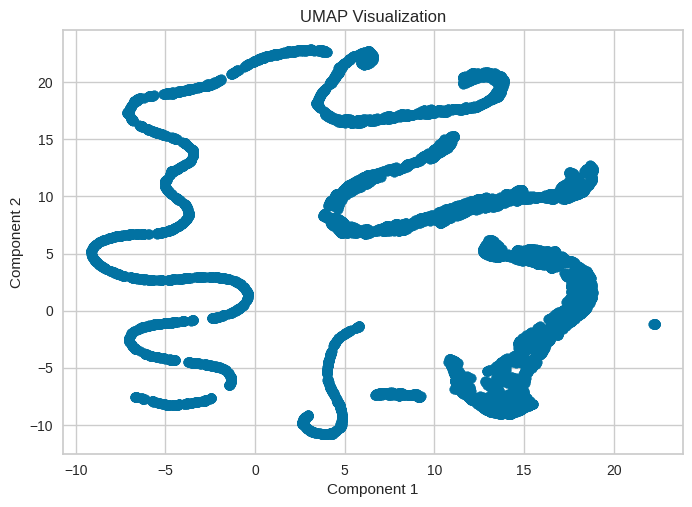

In [46]:
# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=seed)  # Reduce to 2D for visualization
X_embedded = reducer.fit_transform(X_values)

# Visualize the results
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title('UMAP Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Conclusions.

#### A predictive model was developed improving the customer subscription rate from 7% to 11%.  The rate of campaigns needed per subsriber improved from 40 to 26, a 35% reduction.